<a href="https://colab.research.google.com/github/Arash-Razi/ML_Dr_Aliyari_Course_2025/blob/main/MiniP1/ML2025_MiniP1_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align = center>
<img src="https://upload.wikimedia.org/wikipedia/en/d/d2/K._N._Toosi_University_of_Technology.png" width = 200 height = 200>
<br>
<font color=0F5298 size=6>
Machine Learning - First Mini-Project
<font color=696880 size=5>
<br>
Department of Electrical Engineering
<br>
K.N. Toosi University of Technology
<br>
Authors:
<font color=GREEN size=5>
<br>
Reza Shahriari Benny
<br>
Arash Razi
<font color=696880 size=5>
<br>
Instructor:
<font color=GREEN size=5>
<br>
M. Aliyari Sh.


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

## First Question : Weather Forcast Dataset
- In this Question we make use of the weather forcast dataset provided by Kaggle to implement a regression algorithm. Firstly we must throughly understand the dataset.

- In order to get to understand the dataset, we make use of pandas library to identify key features in the dataset.

In [ ]:
import kagglehub

#Downloading the dataset
path = kagglehub.dataset_download("thedevastator/weather-prediction")

print("Path to dataset files:", path)

#View Downloaded Files:
!ls /root/.cache/kagglehub/datasets/thedevastator/weather-prediction/versions/2

100%|██████████| 936k/936k [00:00<00:00, 82.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/thedevastator/weather-prediction/versions/2
metadata.txt  weather_prediction_bbq_labels.csv  weather_prediction_dataset.csv


- **Getting to know the dataset involves reading an exceprt of the metadata.txt. The information are as follows:**

- "... The initial meteorological data was retrieved from ECA&D a project that makes available daily
observations at meteorological stations throughout Europe and the Mediterranean. 18 different European
cities or places were selected of which multiple daily observations were available through the
years 2000 to 2010. Those where **Basel (Switzerland)**, **Budapest (Hungary)**, **Dresden**, **Düsseldorf**, **Kassel**, **München** **(all  Germany)**, **De Bilt** and **Maastricht (the Netherlands)**, **Heathrow (UK)**, **Ljubljana (Slovenia)**,**Malmo and Stockholm (Sweden)**, **Montélimar, Perpignan and Tours (France)**, **Oslo (Norway), Roma (Italy), and Sonnblick (Austria).**"

- "... Recordings of daily meteorological observations for these **18 locations** span different times, some contain
collections that go back to the 19th century. Here, however, we only selected the time span from **2000 to 2010** resulting in 3654 daily observations. The dataset is then constructed from all data of those 18 locations.

- The data in addition consists of different observations. While all selected locations provide data
for the variables **‘mean temperature’**, **‘max temperature’**, and **‘min temperature’**, we also included
data for the variables **'cloud_cover'**, **'wind_speed'**, **'wind_gust'**, **'humidity'**, **'pressure'**, **'global_radiation'**, **'precipitation'**, **'sunshine'** wherever those were available."

- "**Physical units** of the variables:

  ...

  CONVERTED to:

 - CC   : cloud cover in oktas

 - DD   : wind direction in degrees

 - FG   : wind speed in 1 m/s

 - FX   : wind gust in 1 m/s

 - HU   : humidity in fraction of 100 %

 -  PP   : sea level pressure in 1000 hPa

  - QQ   : global radiation in 100 W/m2

  - RR   : precipitation amount in 10 mm

 - SS   : sunshine in 1 Hours

 - TG   : mean temperature in 1 &#176;C

  - TN   : minimum temperature in 1 &#176;C
  
 - TX   : maximum temperature in 1 &#176;C"

In [ ]:
#Load Data:
weather_prediction_dataset = f"{path}/weather_prediction_dataset.csv"
weather_prediction_bbq_labels = f"{path}/weather_prediction_bbq_labels.csv"
df_wpd = pd.read_csv(weather_prediction_dataset)
df_wpbbql = pd.read_csv(weather_prediction_bbq_labels)

#Take out France Data: "Montélimar, Perpignan and Tours":
df_france = df_wpd.loc[:,df_wpd.columns.str.contains("Montelimar|Perpignan|Tours",case=False)]
#Min-Max Normalization (As stated in the original paper):
df_france = (df_france - df_france.min()) / (df_france.max() - df_france.min())
df_france
#Dividing Train and Test
df_france_train = df_france.loc[range(0,3289),:]
df_france_test = df_france.loc[range(3289,3654),:]
#Reseting the Index: Changing 3268-3654 to 0-364:
df_france_test = df_france_test.reset_index(drop=True)
df_france_test.index.size

365

- Implementing **Sliding Window Algorithm** for our test and train datasets

In [ ]:
def sliding_window(df, window_size, stride=1):
    """
    Apply a sliding window transformation on a DataFrame.

    Parameters:
    df : pd.DataFrame - Input data
    window_size : int - Number of past time steps per sample
    stride : int - Step size for moving the window

    Returns:
    np.array - 3D array of shape (num_samples, window_size, num_features)
    """
    # Number of features
    n = df.shape[1]

    # Number of samples based on stride
    num_samples = (df.shape[0] - window_size) // stride + 1

    # Convert DataFrame to NumPy array
    data = df.values  # Shape: (time_steps, features)

    # Create sliding window view
    windows = np.lib.stride_tricks.sliding_window_view(data, (window_size, n))

    # Reshape the Dimension:
    windows = windows.reshape(num_samples,window_size,n)

    # Apply stride by selecting every 'stride' step
    windows = windows[::stride]  # Shape: (num_samples, window_size, n)

    return windows

- Now to run the algorithm on our test and train data

In [ ]:
#Making Widnows:Training:
windows_train = sliding_window(df_france_train,5,1)
windows_test = sliding_window(df_france_test,5,1)

#For Predicting xn from a [x0,...,xn] window:
labels_train = df_france_train.iloc[4:,:]
labels_test = df_france_test.iloc[4:,:]

print(windows_train.shape)
print(windows_test.shape)
print(labels_train.shape)
print(labels_test.shape)

(3285, 5, 24)
(361, 5, 24)
(3285, 24)
(361, 24)


**Collaborative Machine Learning**:

- In collaborative machine learning the data from various locations are used to predict the features of one location.

- In order to implement collaborative machine learning we must write a simple linear regression algorithm

In [ ]:
class CollaborativeMachineLearning:
    def __init__(self, learning_rate=0.01, num_iterations=1000, error_threshold=None):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.mse_history = []  # Store MSE history for each epoch
        self.error_threshold = error_threshold  # Add error threshold parameter
        self.stopped_early = False  # Flag to indicate if early stopping occurred
        self.stopped_at_epoch = None  # Store the epoch at which training stopped

    def fit(self, X, y):
        # Initialize weights and bias:
        num_samples, num_features = X.shape
        _, num_labels = y.shape
        self.weights = np.zeros((num_features, num_labels))  # Initialize with zeros for stability
        self.bias = np.zeros((num_labels))
        self.mse_history = []  # Reset MSE history
        self.stopped_early = False
        self.stopped_at_epoch = None

        # Create tqdm progress bar outside the loop
        progress_bar = tqdm(total=self.num_iterations, desc="Epoch")

        # Perform Gradient Descent:
        for epoch in range(self.num_iterations):
            # Calculate Predictions:
            y_pred = np.dot(X, self.weights) + self.bias

            # Calculate The Error:
            error = y_pred - y

            # Calculate Gradients
            gradients_weights = (1/num_samples) * np.dot(X.T, error)
            gradients_bias = (1/num_samples) * np.sum(error, axis=0)

            # Update Weights:
            self.weights -= self.learning_rate * gradients_weights
            self.bias -= self.learning_rate * gradients_bias

            # Calculate MSE for each feature
            mse_per_feature = np.mean((y_pred - y) ** 2, axis=0)
            overall_mse = np.mean(mse_per_feature)  # Calculate average MSE across all features
            self.mse_history.append(mse_per_feature)

            # Update progress bar for every epoch
            progress_bar.update(1)

            # Print MSE info every 100 epochs without disrupting progress bar
            if (epoch + 1) % 100 == 0:
                progress_bar.set_postfix(MSE=f"{overall_mse:.6f}")

            # Check if error is below threshold for early stopping
            if self.error_threshold is not None and overall_mse < self.error_threshold:
                progress_bar.close()  # Close the progress bar before printing message
                print(f"\nEarly stopping at epoch {epoch + 1}: Average MSE {overall_mse:.6f} is below threshold {self.error_threshold}")
                for i, feature_mse in enumerate(mse_per_feature):
                    print(f"MSE for Feature {i}: {feature_mse:.6f}")
                self.stopped_early = True
                self.stopped_at_epoch = epoch + 1
                return  # Exit the function

        # Close progress bar at the end
        progress_bar.close()

        # Final summary after all epochs or if stopped early
        print(f"\nTraining completed after {len(self.mse_history)} epochs")
        print(f"Final average MSE: {overall_mse:.6f}")
        for i, feature_mse in enumerate(mse_per_feature):
            print(f"MSE for Feature {i}: {feature_mse:.6f}")

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

    def plot_mse_history(self):
        """Plot the MSE history for each feature"""
        import matplotlib.pyplot as plt

        mse_history_array = np.array(self.mse_history)
        plt.figure(figsize=(12, 6))

        # Plot individual feature MSEs
        for i in range(mse_history_array.shape[1]):
            plt.plot(mse_history_array[:, i], label=f'Feature {i}')

        # Plot average MSE across all features
        avg_mse = np.mean(mse_history_array, axis=1)
        plt.plot(avg_mse, 'k--', linewidth=2, label='Average MSE')

        # Add error threshold line if applicable
        if self.error_threshold is not None:
            plt.axhline(y=self.error_threshold, color='r', linestyle='-',
                        label=f'Error Threshold: {self.error_threshold}')

        # Mark early stopping point if applicable
        if self.stopped_early:
            plt.axvline(x=self.stopped_at_epoch-1, color='g', linestyle='--',
                       label=f'Early Stopping: Epoch {self.stopped_at_epoch}')

        plt.xlabel('Epoch')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE per Feature over Training Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

**Labeling The Dataset**:
- Based on what is asked in the homework the dataset must be labeled in two ways:
  - Predicting $x_t$ based on $x_{t-1}$.
  - The Sliding Windows: The code of which is written above.


In [ ]:
def create_one_step_prediction_data(df):
    """
    Create X and y datasets for predicting x_t based on x_(t-1)

    Parameters:
    df : pandas DataFrame - Time data

    Returns:
    X : numpy array - Features (data at time t-1)
    y : numpy array - Target (data at time t)
    """
    # X will be all rows except the last one
    X = df.iloc[:-1].values

    # y will be all rows except the first one
    y = df.iloc[1:].values

    return X, y

# Create train datasets
X_train, y_train = create_one_step_prediction_data(df_france_train)

# Create test datasets
X_test, y_test = create_one_step_prediction_data(df_france_test)

- Now to test the code that we have written we do the following. Based on what is asked in the homework a seperate model is trained for every feature. And a seperate MSE (Error) is calculated at the end of the training loop.

Epoch:  22%|██▏       | 215/1000 [00:01<00:04, 183.35it/s, MSE=0.010186]



Early stopping at epoch 215: Average MSE 0.009988 is below threshold 0.01
MSE for Feature 0: 0.017412
MSE for Feature 1: 0.015621
MSE for Feature 2: 0.010364
MSE for Feature 3: 0.017349
MSE for Feature 4: 0.003367
MSE for Feature 5: 0.003339
MSE for Feature 6: 0.005447
MSE for Feature 7: 0.004121
MSE for Feature 8: 0.021812
MSE for Feature 9: 0.022205
MSE for Feature 10: 0.009658
MSE for Feature 11: 0.019716
MSE for Feature 12: 0.002400
MSE for Feature 13: 0.004308
MSE for Feature 14: 0.006523
MSE for Feature 15: 0.004960
MSE for Feature 16: 0.019406
MSE for Feature 17: 0.012133
MSE for Feature 18: 0.002186
MSE for Feature 19: 0.018801
MSE for Feature 20: 0.004115
MSE for Feature 21: 0.004093
MSE for Feature 22: 0.005598
MSE for Feature 23: 0.004791


Epoch: 100%|██████████| 1000/1000 [00:03<00:00, 266.18it/s, MSE=0.010965]



Training completed after 1000 epochs
Final average MSE: 0.010965
MSE for Feature 0: 0.018301
MSE for Feature 1: 0.017439
MSE for Feature 2: 0.009262
MSE for Feature 3: 0.022183
MSE for Feature 4: 0.003463
MSE for Feature 5: 0.003292
MSE for Feature 6: 0.005594
MSE for Feature 7: 0.003898
MSE for Feature 8: 0.023476
MSE for Feature 9: 0.024528
MSE for Feature 10: 0.008762
MSE for Feature 11: 0.024744
MSE for Feature 12: 0.002441
MSE for Feature 13: 0.004695
MSE for Feature 14: 0.006839
MSE for Feature 15: 0.005373
MSE for Feature 16: 0.020254
MSE for Feature 17: 0.014017
MSE for Feature 18: 0.002103
MSE for Feature 19: 0.023958
MSE for Feature 20: 0.004324
MSE for Feature 21: 0.003959
MSE for Feature 22: 0.005338
MSE for Feature 23: 0.004921

Overall MSE For Windowed: 0.010029467983177495
Overall MSE for One Time: 0.011115101180273623


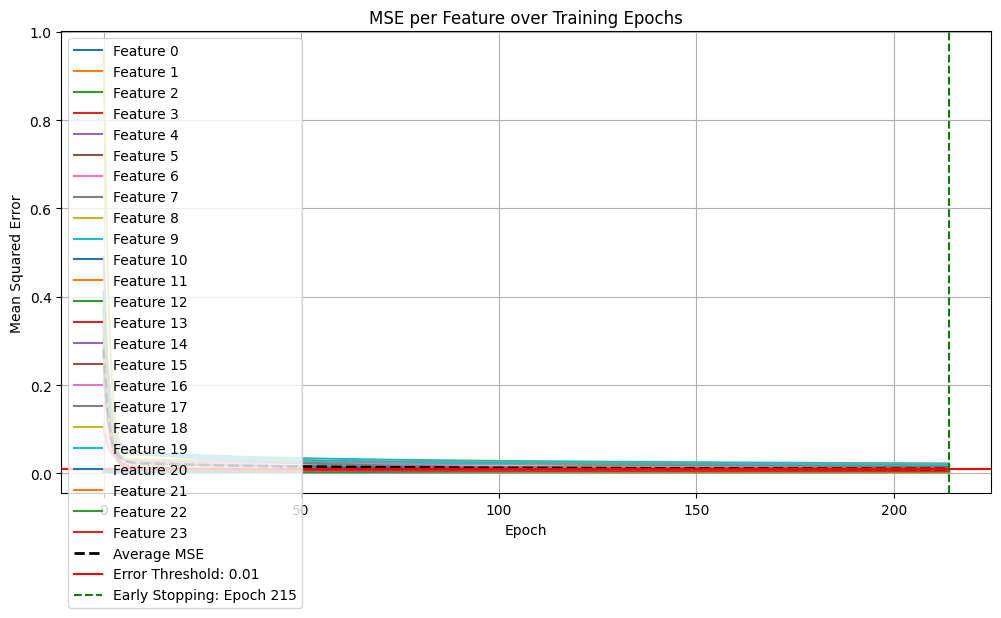

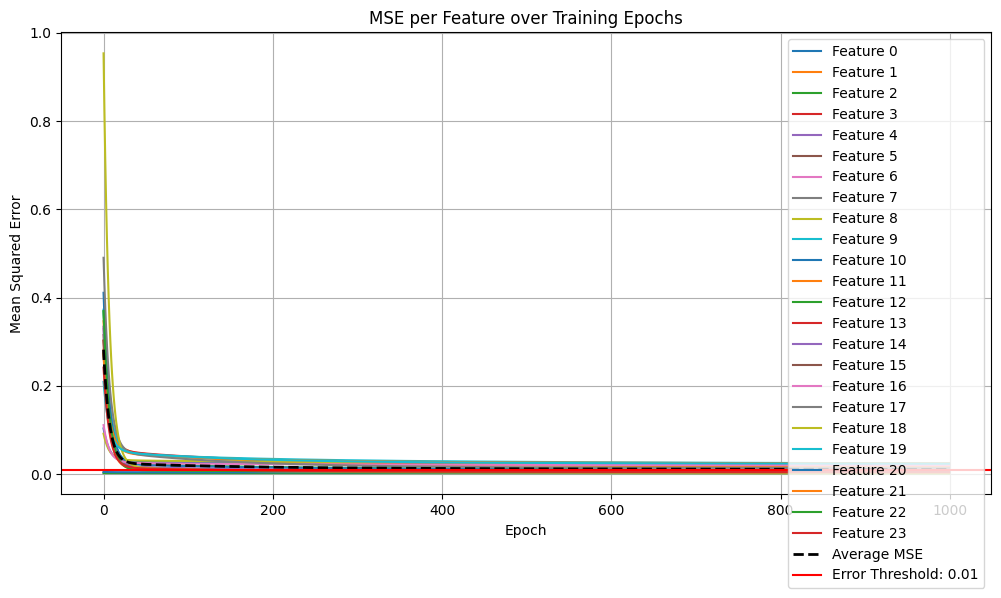

In [ ]:
# Reshape the windowed data to 2D:
windows_train_2d = windows_train.reshape(windows_train.shape[0], -1)  # Shape: (num_samples, window_size * num_features)
windows_test_2d = windows_test.reshape(windows_test.shape[0], -1)  # Shape: (num_samples, window_size * num_features)


model_windowed = CollaborativeMachineLearning(learning_rate=0.01, num_iterations=1000, error_threshold=0.01)
model_one_time = CollaborativeMachineLearning(learning_rate=0.01, num_iterations=1000,error_threshold=0.01)

# Get the target for this specific feature
y_train_feature_windowed = labels_train.values

# Train the model
model_windowed.fit(windows_train_2d, y_train_feature_windowed)
model_one_time.fit(X_train, y_train)

# Making predictions with model
predictions_windowed = model_windowed.predict(windows_test_2d)
predictions_one_time = model_one_time.predict(X_test)

# Calculate MSE for each model
mse_for_windowed = np.mean((predictions_windowed - labels_test.values) ** 2, axis=0)
mse_for_one_time = np.mean((predictions_one_time - y_test) ** 2,axis=0)


overall_mse_windowed = np.mean(mse_for_windowed)
overall_mse_one_time = np.mean(mse_for_one_time)

print(f"\nOverall MSE For Windowed: {overall_mse_windowed}\nOverall MSE for One Time: {overall_mse_one_time}")

# Visualize training history
model_windowed.plot_mse_history()
model_one_time.plot_mse_history()

**Training Models from Libraries**:
- Based on what is asked in the homework, now we have to choose three **Linear Models**, from scikit-learn library and create a **Linear Regression** algorithm like we had previously written manually. First we analyze our options:

  - **LinearRegression** : is the simpleset option and the closest to what we have written manually but with inner optimization.
  - **Ridge Regression** : Linear regression with L2 regularization, helps prevent overfitting. L2 Regularization is when the square of the weights is minimized or optimized. The idea is to add the term to the loss function which is usually the best way to prevent overfitting.
  - **Lasso Regression** : Linear regression with L1 regularization, good for feature selection

In [ ]:
# import linear models from sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

# List the models that are chosen to use.
models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge", Ridge(alpha=1.0)),
    ("Lasso", Lasso(alpha=0.1))
]

# Train and evaluate each model for each feature
results = []

# Get target for this feature
y_train_feature = labels_train.values
y_test_feature = labels_test.values

for name, model in models:
    # Train
    model.fit(windows_train_2d, y_train_feature)

    # Predict
    y_pred = model.predict(windows_test_2d)

    # Evaluate
    mse = mean_squared_error(y_test_feature, y_pred)
    results.append((name, mse))


# Display results
for name, mse in results:
    print(f"{name}: MSE = {mse:.35f}")

Linear Regression: MSE = 0.00000000000000000000000000000322823
Ridge: MSE = 0.00001826115444655538160305570383191
Lasso: MSE = 0.03392516745258297022891369465469324
